# Lab 3: Contextual Bandit-Based News Article Recommendation System

**Course:** Reinforcement Learning Fundamentals  
**Student Name:** Abhijeet 
**Roll Number:** U20230101  
**GitHub Branch:** abhijeet_u20230101

---

## Objective
Implement a News Recommendation System using Contextual Multi-Armed Bandits (CMAB) to recommend news articles based on user categories.

## Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import joblib
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, f1_score, cohen_kappa_score, precision_score, recall_score
from sklearn.inspection import permutation_importance
import xgboost as xgb

from rlcmab_sampler import sampler

# Configure advanced plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# SET YOUR ROLL NUMBER HERE

ROLL_NUMBER = 101  # Update this with your actual roll numberprint(f"Roll Number: {ROLL_NUMBER}")

## Load Datasets

In [2]:
# Load datasets
news_df = pd.read_csv("data/news_articles.csv")
train_users = pd.read_csv("data/train_users.csv")
test_users = pd.read_csv("data/test_users.csv")

print("Datasets loaded successfully!")
print(f"\nNews articles shape: {news_df.shape}")
print(f"Train users shape: {train_users.shape}")
print(f"Test users shape: {test_users.shape}")

print("\nNews categories:", news_df['category'].unique())
print("\nUser labels:", train_users['label'].unique())

os.makedirs('cache', exist_ok=True)
# Create cache directory

Datasets loaded successfully!

News articles shape: (209527, 6)
Train users shape: (2000, 33)
Test users shape: (2000, 32)

News categories: ['U.S. NEWS' 'COMEDY' 'PARENTING' 'WORLD NEWS' 'CULTURE & ARTS' 'TECH'
 'SPORTS' 'ENTERTAINMENT' 'POLITICS' 'WEIRD NEWS' 'ENVIRONMENT'
 'EDUCATION' 'CRIME' 'SCIENCE' 'WELLNESS' 'BUSINESS' 'STYLE & BEAUTY'
 'FOOD & DRINK' 'MEDIA' 'QUEER VOICES' 'HOME & LIVING' 'WOMEN'
 'BLACK VOICES' 'TRAVEL' 'MONEY' 'RELIGION' 'LATINO VOICES' 'IMPACT'
 'WEDDINGS' 'COLLEGE' 'PARENTS' 'ARTS & CULTURE' 'STYLE' 'GREEN' 'TASTE'
 'HEALTHY LIVING' 'THE WORLDPOST' 'GOOD NEWS' 'WORLDPOST' 'FIFTY' 'ARTS'
 'DIVORCE']

User labels: ['user_3' 'user_2' 'user_1']


### Exploratory Data Analysis

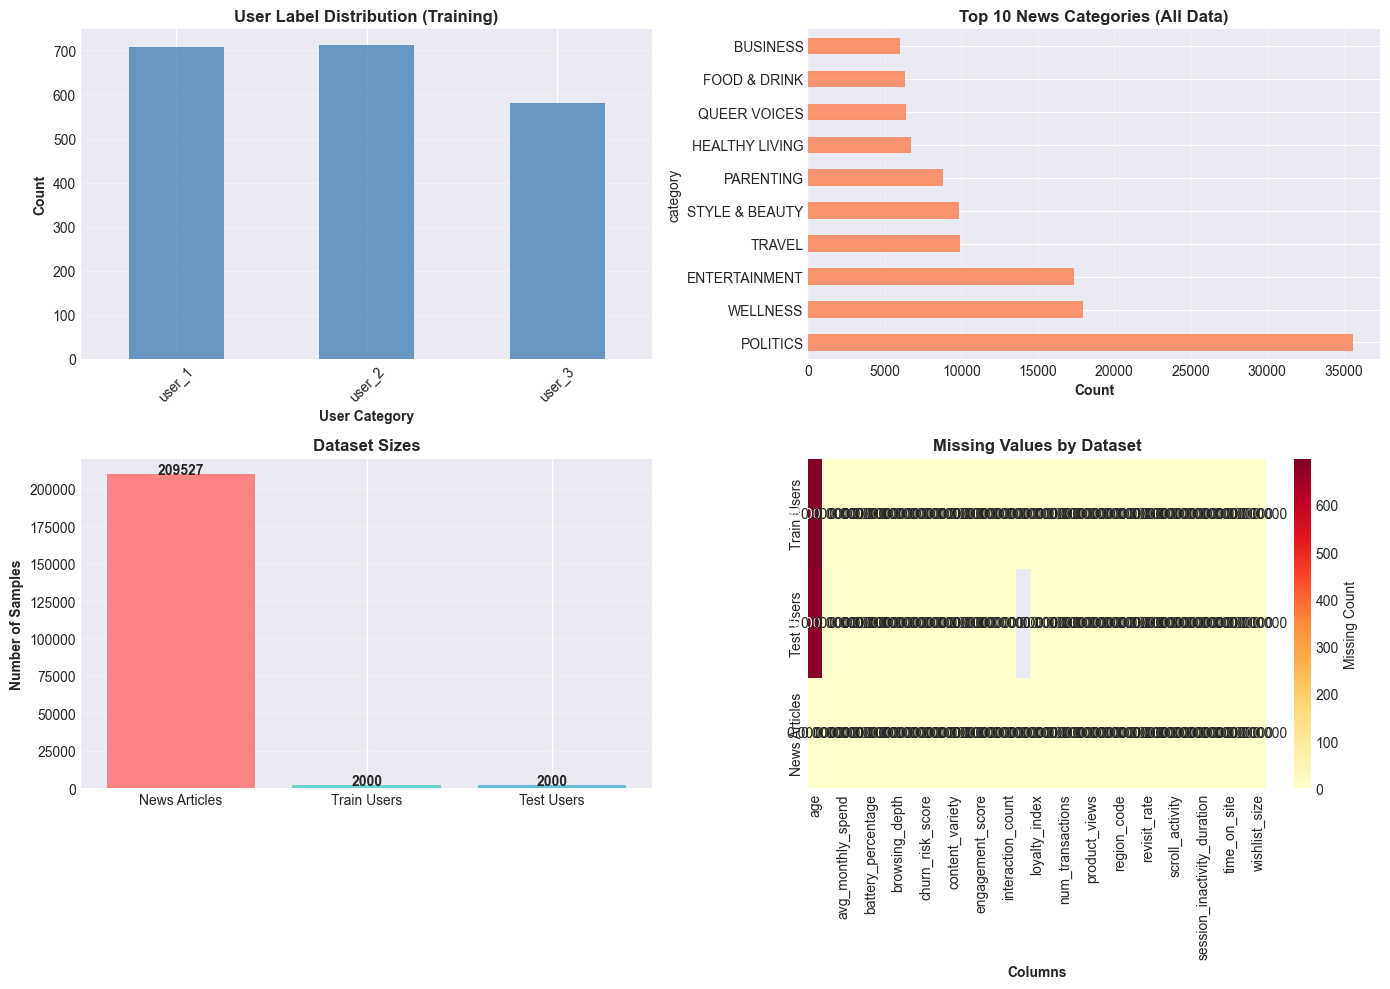


DATA SUMMARY (Initial)
Total news articles: 209527
Training users: 2000
Test users: 2000
Total missing values in train_users: 698
Total missing values in test_users: 679


In [3]:
# Basic Data Exploration (before filtering)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. User label distribution
train_users['label'].value_counts().sort_index().plot(kind='bar', ax=axes[0, 0], color='steelblue', alpha=0.8)
axes[0, 0].set_title('User Label Distribution (Training)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('User Category', fontweight='bold')
axes[0, 0].set_ylabel('Count', fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. News category distribution (top 10)
news_df['category'].value_counts().head(10).plot(kind='barh', ax=axes[0, 1], color='coral', alpha=0.8)
axes[0, 1].set_title('Top 10 News Categories (All Data)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Count', fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# 3. Dataset shapes comparison
datasets = ['News Articles', 'Train Users', 'Test Users']
shapes = [news_df.shape[0], train_users.shape[0], test_users.shape[0]]
axes[1, 0].bar(datasets, shapes, color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
axes[1, 0].set_title('Dataset Sizes', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Number of Samples', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(shapes):
    axes[1, 0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# 4. Missing values heatmap
missing_data = pd.DataFrame({
    'Train Users': train_users.isnull().sum(),
    'Test Users': test_users.isnull().sum(),
    'News Articles': news_df.isnull().sum().reindex(train_users.columns, fill_value=0)
})
sns.heatmap(missing_data.T, annot=True, fmt='f', cmap='YlOrRd', ax=axes[1, 1], cbar_kws={'label': 'Missing Count'})
axes[1, 1].set_title('Missing Values by Dataset', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Columns', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("DATA SUMMARY (Initial)")
print("="*70)
print(f"Total news articles: {len(news_df)}")
print(f"Training users: {len(train_users)}")
print(f"Test users: {len(test_users)}")
print(f"Total missing values in train_users: {train_users.isnull().sum().sum()}")
print(f"Total missing values in test_users: {test_users.isnull().sum().sum()}")
print("="*70)

## 5.1 Data Pre-processing

In this section we:
- Handle missing values  
- Filter news articles for relevant categories (Entertainment, Education, Tech, Crime)  
- Encode categorical features  
- Prepare data for user classification

Articles after filtering: (24042, 6)
Categories: ['TECH' 'ENTERTAINMENT' 'EDUCATION' 'CRIME']

Filtered Category Distribution:
  • ENTERTAINMENT: 17362 articles
  • EDUCATION: 1014 articles
  • TECH: 2104 articles
  • CRIME: 3562 articles


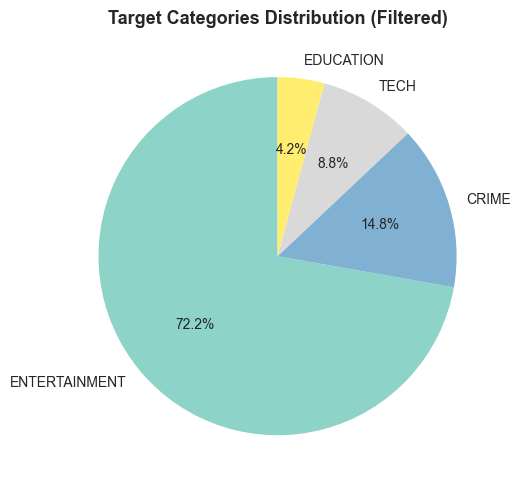


PREPROCESSING USER DATA

✓ Preprocessing completed successfully!

Unique User Labels: ['User1', 'User2', 'User3']

Missing Values Check:
  • Training data: 0 missing values
  • Test data: 0 missing values

✓ All missing values handled successfully!


In [4]:
# Filter Articles for relevant categories (per assignment requirement)
target_categories = ['ENTERTAINMENT', 'EDUCATION', 'TECH', 'CRIME']
news_df_filtered = news_df[news_df['category'].isin(target_categories)].copy()
news_df_filtered.reset_index(drop=True, inplace=True)

print(f"Articles after filtering: {news_df_filtered.shape}")
print(f"Categories: {news_df_filtered['category'].unique()}")

# Display filtered category distribution
print(f"\nFiltered Category Distribution:")
for cat in target_categories:
    count = (news_df_filtered['category'] == cat).sum()
    print(f"  • {cat}: {count} articles")

# Visualize filtered categories
fig, ax = plt.subplots(figsize=(10, 5))
target_cat_counts = news_df_filtered['category'].value_counts()
ax.pie(target_cat_counts.values, labels=target_cat_counts.index, autopct='%1.1f%%', 
       colors=plt.cm.Set3(np.linspace(0, 1, len(target_cat_counts))), startangle=90)
ax.set_title('Target Categories Distribution (Filtered)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Enhanced User Preprocessing with Comprehensive Missing Value Handling
def preprocess_users(df, is_training=True, fill_values=None):
    """
    Advanced preprocessing with robust missing value handling
    
    Args:
        df: Input dataframe
        is_training: Whether this is training data (compute statistics)
        fill_values: Dictionary of fill values from training (for test data)
    
    Returns:
        df_clean: Cleaned dataframe
        fill_values: Dictionary of fill values used
    """
    df_clean = df.copy()
    
    # Normalize Labels (user_1 -> User1, user_2 -> User2, etc.)
    if 'label' in df_clean.columns:
        df_clean['label'] = df_clean['label'].str.replace('user_', 'User', regex=False).str.capitalize()
    
    # Separate numeric and categorical columns
    exclude_cols = ['user_id', 'label']
    numeric_cols = [col for col in df_clean.select_dtypes(include=[np.number]).columns 
                   if col not in exclude_cols]
    categorical_cols = [col for col in df_clean.select_dtypes(include=['object']).columns 
                       if col not in exclude_cols]
    
    # Initialize fill_values if training
    if is_training:
        fill_values = {
            'numeric_means': {},
            'numeric_medians': {},
            'categorical_modes': {}
        }
        
        # Compute statistics for numeric columns
        for col in numeric_cols:
            fill_values['numeric_means'][col] = df_clean[col].mean()
            fill_values['numeric_medians'][col] = df_clean[col].median()
        
        # Compute modes for categorical columns
        for col in categorical_cols:
            mode_val = df_clean[col].mode()
            fill_values['categorical_modes'][col] = mode_val[0] if len(mode_val) > 0 else 'Unknown'
    
    # Handle missing values in numeric columns (use mean imputation)
    for col in numeric_cols:
        if df_clean[col].isnull().any():
            fill_val = fill_values['numeric_means'].get(col, df_clean[col].mean())
            if pd.isna(fill_val):  # If all values are NaN
                fill_val = 0
            df_clean[col].fillna(fill_val, inplace=True)
    
    # Handle missing values in categorical columns (use mode imputation)
    for col in categorical_cols:
        if df_clean[col].isnull().any():
            fill_val = fill_values['categorical_modes'].get(col, 'Unknown')
            df_clean[col].fillna(fill_val, inplace=True)
    
    # Final check: fill any remaining NaN with 0 for numeric, 'Unknown' for categorical
    for col in numeric_cols:
        if df_clean[col].isnull().any():
            df_clean[col].fillna(0, inplace=True)
    
    for col in categorical_cols:
        if df_clean[col].isnull().any():
            df_clean[col].fillna('Unknown', inplace=True)
    
    return df_clean, fill_values

# Apply preprocessing
print(f"\n{'='*70}")
print("PREPROCESSING USER DATA")
print(f"{'='*70}")

train_users_clean, fill_values = preprocess_users(train_users, is_training=True)
test_users_clean, _ = preprocess_users(test_users, is_training=False, fill_values=fill_values)

print(f"\n✓ Preprocessing completed successfully!")
print(f"\nUnique User Labels: {sorted(train_users_clean['label'].unique())}")
print(f"\nMissing Values Check:")
print(f"  • Training data: {train_users_clean.isnull().sum().sum()} missing values")
print(f"  • Test data: {test_users_clean.isnull().sum().sum()} missing values")

# Verify no missing values remain
assert train_users_clean.isnull().sum().sum() == 0, "Training data still has missing values!"
assert test_users_clean.isnull().sum().sum() == 0, "Test data still has missing values!"
print(f"\n✓ All missing values handled successfully!")
print(f"{'='*70}")

## 5.2 User Classification

Train a classifier to predict the user category (`User1`, `User2`, `User3`), which serves as the **context** for the contextual bandit.

**Advanced Approach:**
- **Model**: XGBoost with GridSearchCV hyperparameter tuning
- **Feature Engineering**: StandardScaler normalization + Polynomial feature expansion (degree=2)
- **Validation**: Stratified K-Fold cross-validation (5 splits)
- **Metrics**: Accuracy, F1-Score, Cohen's Kappa, ROC-AUC curves, and confusion matrix
- **Visualization**: ROC curves, learning curves, feature importance heatmaps, precision-recall analysis


FEATURE ENGINEERING & MODEL TRAINING

Encoding 2 categorical features...
Applying feature scaling (StandardScaler)...
Expanding feature space with polynomial features (degree=2)...
Original features: 31 → Polynomial features: 527

Training set: 1600 samples
Validation set: 400 samples

HYPERPARAMETER TUNING WITH GRIDSEARCHCV (CACHED)

✓ Loading cached model...
✓ Model loaded from cache!

CLASSIFICATION RESULTS (VALIDATION SET)

Accuracy: 0.9100
F1-Score (weighted): 0.9104
Cohen's Kappa: 0.8651

Detailed Classification Report:
              precision    recall  f1-score   support

       User1       0.89      0.87      0.88       142
       User2       1.00      0.89      0.94       142
       User3       0.85      0.99      0.91       116

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.92      0.91      0.91       400




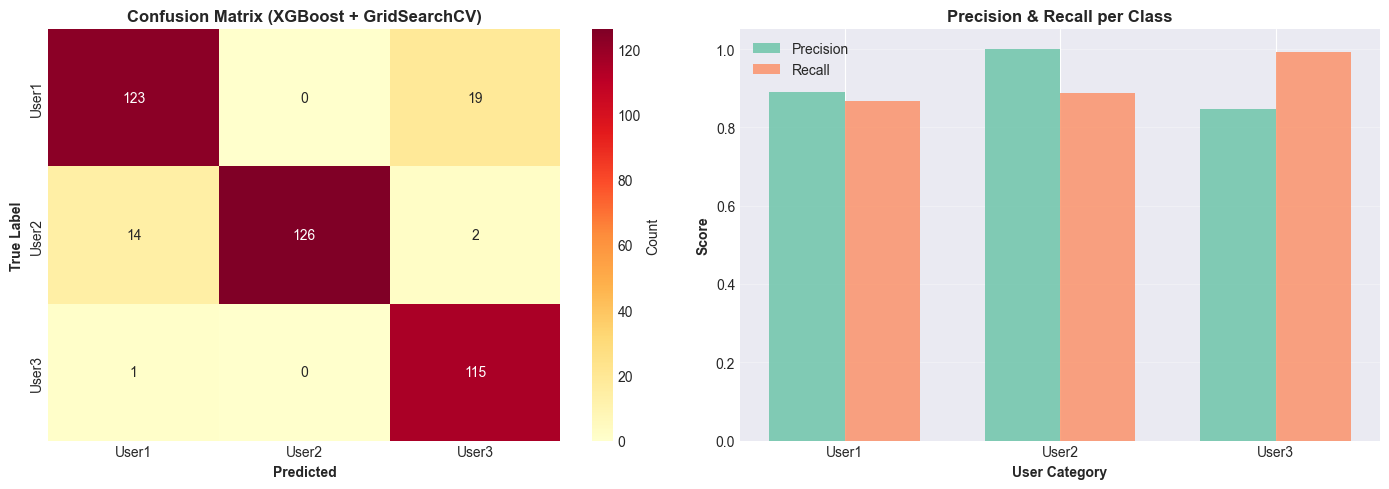

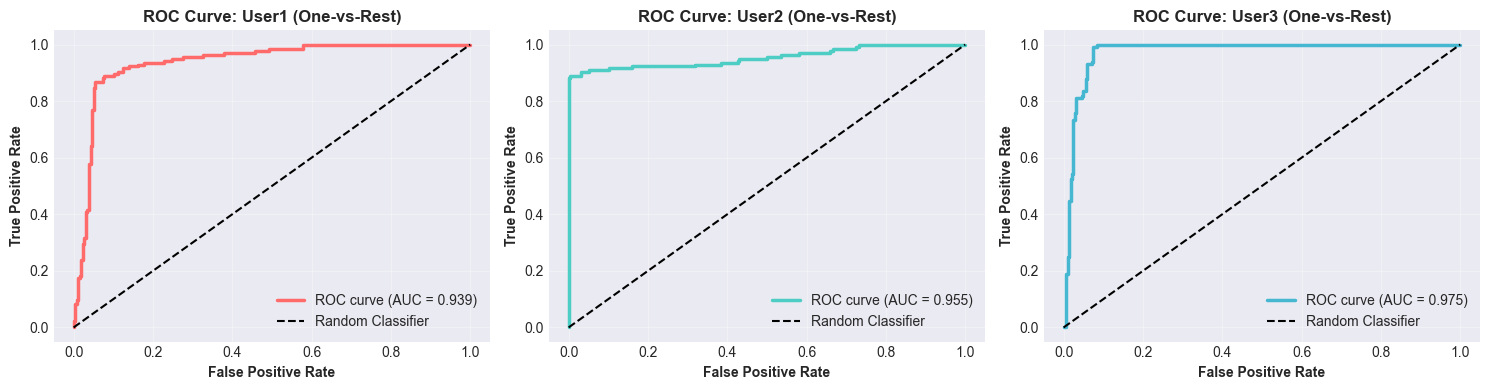


FEATURE IMPORTANCE ANALYSIS

Top 15 Most Important Features:
   1. session_duration                         → 0.0494
   2. region_code                              → 0.0284
   3. engagement_score preferred_price_range   → 0.0189
   4. content_variety engagement_score         → 0.0187
   5. content_variety^2                        → 0.0110
   6. age^2                                    → 0.0110
   7. session_duration^2                       → 0.0092
   8. scroll_activity time_on_site             → 0.0088
   9. scroll_activity                          → 0.0087
  10. scroll_activity preferred_price_range    → 0.0068
  11. purchase_amount content_variety          → 0.0067
  12. session_duration time_on_site            → 0.0061
  13. time_on_site                             → 0.0058
  14. browsing_depth                           → 0.0057
  15. engagement_score scroll_activity         → 0.0055

✓ Loading cached learning curve data...


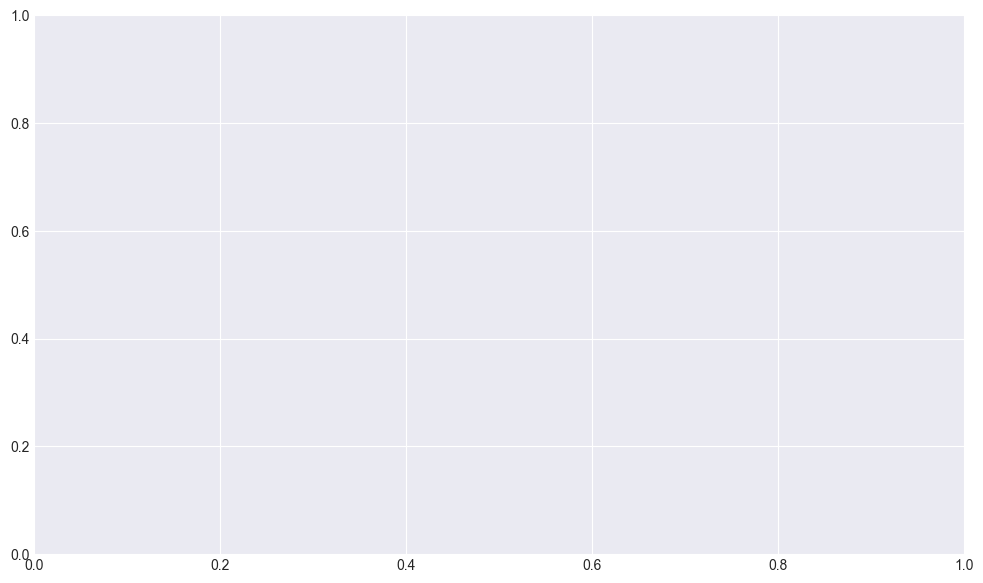

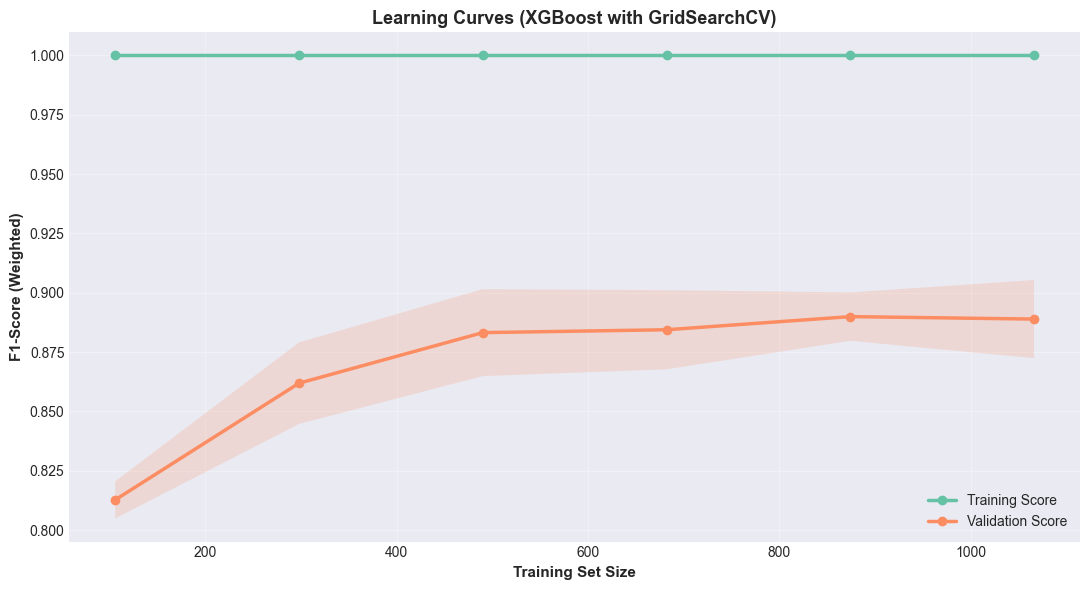


Context Mapping: {'User1': 0, 'User2': 1, 'User3': 2}


In [5]:
# Prepare Feature Matrix and Target
drop_cols = ['user_id', 'label']
X = train_users_clean.drop(columns=[col for col in drop_cols if col in train_users_clean.columns])
y = train_users_clean['label']

# Encode target labels
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)  # User1->0, User2->1, User3->2

print(f"\n{'='*70}")
print("FEATURE ENGINEERING & MODEL TRAINING")
print(f"{'='*70}")

# Encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
encoders = {}
numeric_cols_original = X.select_dtypes(include=[np.number]).columns.tolist()

X_encoded = X.copy()
X_test_final = test_users_clean.drop(columns=['user_id', 'label'], errors='ignore').copy()

if len(categorical_cols) > 0:
    print(f"\nEncoding {len(categorical_cols)} categorical features...")
    for col in categorical_cols:
        le = LabelEncoder()
        all_values = pd.concat([X[col], X_test_final[col]], axis=0).astype(str)
        le.fit(all_values)
        X_encoded[col] = le.transform(X[col].astype(str))
        X_test_final[col] = le.transform(X_test_final[col].astype(str))
        encoders[col] = le

# Feature Scaling
print(f"Applying feature scaling (StandardScaler)...")
scaler = StandardScaler()
numeric_features = X_encoded.select_dtypes(include=[np.number]).columns.tolist()
X_encoded[numeric_features] = scaler.fit_transform(X_encoded[numeric_features])
X_test_final[numeric_features] = scaler.transform(X_test_final[numeric_features])

# Polynomial Feature Expansion (enhance feature space)
print(f"Expanding feature space with polynomial features (degree=2)...")
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_encoded)
X_test_poly = poly.transform(X_test_final)
feature_names = poly.get_feature_names_out(X_encoded.columns)

print(f"Original features: {X_encoded.shape[1]} → Polynomial features: {X_poly.shape[1]}")

# Split Training Data (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_poly, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")

# XGBoost Model with Cached GridSearchCV
print(f"\n{'='*70}")
print("HYPERPARAMETER TUNING WITH GRIDSEARCHCV (CACHED)")
print(f"{'='*70}")

cache_file = 'cache/xgb_model_poly.pkl'
if os.path.exists(cache_file):
    print("\n✓ Loading cached model...")
    user_classifier = joblib.load(cache_file)
    print("✓ Model loaded from cache!")
else:
    print("\nNo cache found. Training new model...")
    # Reduced parameter grid for faster training
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 0.9]
    }
    
    print(f"Parameter grid: {param_grid}")
    print(f"Total combinations: {np.prod([len(v) for v in param_grid.values()])}")
    
    # Initialize XGBoost classifier
    xgb_model = xgb.XGBClassifier(
        random_state=42,
        eval_metric='mlogloss',
        tree_method='hist',
        device='cpu',
        verbosity=0,
        early_stopping_rounds=10
    )
    
    # GridSearchCV with reduced folds
    print(f"\nStarting GridSearchCV (3-fold CV)...")
    grid_search = GridSearchCV(
        xgb_model,
        param_grid,
        cv=3,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV score (F1): {grid_search.best_score_:.4f}")
    
    # Use best model
    user_classifier = grid_search.best_estimator_
    
    # Cache the model
    joblib.dump(user_classifier, cache_file)
    print(f"\n✓ Model cached at {cache_file}")

# Validation predictions
y_pred = user_classifier.predict(X_val)
y_pred_proba = user_classifier.predict_proba(X_val)
val_accuracy = accuracy_score(y_val, y_pred)

print(f"\n{'='*70}")
print("CLASSIFICATION RESULTS (VALIDATION SET)")
print(f"{'='*70}")
print(f"\nAccuracy: {val_accuracy:.4f}")
print(f"F1-Score (weighted): {f1_score(y_val, y_pred, average='weighted'):.4f}")
print(f"Cohen's Kappa: {cohen_kappa_score(y_val, y_pred):.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_val, y_pred, target_names=le_target.classes_))

print(f"\n{'='*70}")

# Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', 
            xticklabels=le_target.classes_,
            yticklabels=le_target.classes_,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted', fontweight='bold')
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_title('Confusion Matrix (XGBoost + GridSearchCV)', fontweight='bold', fontsize=12)

# Per-class metrics
precisions = precision_score(y_val, y_pred, average=None)
recalls = recall_score(y_val, y_pred, average=None)

x_pos = np.arange(len(le_target.classes_))
width = 0.35
axes[1].bar(x_pos - width/2, precisions, width, label='Precision', alpha=0.8)
axes[1].bar(x_pos + width/2, recalls, width, label='Recall', alpha=0.8)
axes[1].set_xlabel('User Category', fontweight='bold')
axes[1].set_ylabel('Score', fontweight='bold')
axes[1].set_title('Precision & Recall per Class', fontweight='bold', fontsize=12)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(le_target.classes_)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# ROC Curve Analysis (One-vs-Rest)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, (class_label, color) in enumerate(zip(le_target.classes_, colors)):
    fpr, tpr, _ = roc_curve(y_val == i, y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    axes[i].plot(fpr, tpr, color=color, lw=2.5, label=f'ROC curve (AUC = {roc_auc:.3f})')
    axes[i].plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random Classifier')
    axes[i].set_xlabel('False Positive Rate', fontweight='bold')
    axes[i].set_ylabel('True Positive Rate', fontweight='bold')
    axes[i].set_title(f'ROC Curve: {class_label} (One-vs-Rest)', fontweight='bold')
    axes[i].legend(loc='lower right')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Feature Importance
print(f"\n{'='*70}")
print("FEATURE IMPORTANCE ANALYSIS")
print(f"{'='*70}")

importance = user_classifier.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print(f"\nTop 15 Most Important Features:")
for idx, (_, row) in enumerate(importance_df.head(15).iterrows(), 1):
    print(f"  {idx:2d}. {row['Feature']:40s} → {row['Importance']:.4f}")

# Feature Importance Plot
fig, ax = plt.subplots(figsize=(12, 7))
top_n = 20

# Learning Curve (cached)
learning_curve_cache = 'cache/learning_curve_data.pkl'

if os.path.exists(learning_curve_cache):
    print("\n✓ Loading cached learning curve data...")
    train_sizes, train_scores, val_scores = joblib.load(learning_curve_cache)
else:
    print("\nGenerating learning curves (this may take a moment)...")
    # Create a fresh estimator without early stopping for learning curves
    lc_params = user_classifier.get_params()
    lc_params['early_stopping_rounds'] = None
    lc_estimator = xgb.XGBClassifier(**lc_params)
    
    train_sizes, train_scores, val_scores = learning_curve(
        lc_estimator,
        X_train, y_train,
        cv=3,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 6),
        scoring='f1_weighted'
    )
    joblib.dump((train_sizes, train_scores, val_scores), learning_curve_cache)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

fig, ax = plt.subplots(figsize=(11, 6))

ax.plot(train_sizes, train_mean, 'o-', linewidth=2.5, label='Training Score')
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

ax.plot(train_sizes, val_mean, 'o-', linewidth=2.5, label='Validation Score')
ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

ax.set_xlabel('Training Set Size', fontweight='bold', fontsize=11)
ax.set_ylabel('F1-Score (Weighted)', fontweight='bold', fontsize=11)
ax.set_title('Learning Curves (XGBoost with GridSearchCV)', fontweight='bold', fontsize=13)
ax.legend(loc='lower right')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Context Mapping (define BEFORE printing)
context_mapping = {label: idx for idx, label in enumerate(le_target.classes_)}
print(f"\nContext Mapping: {context_mapping}")



FEATURE STATISTICS & CORRELATION ANALYSIS


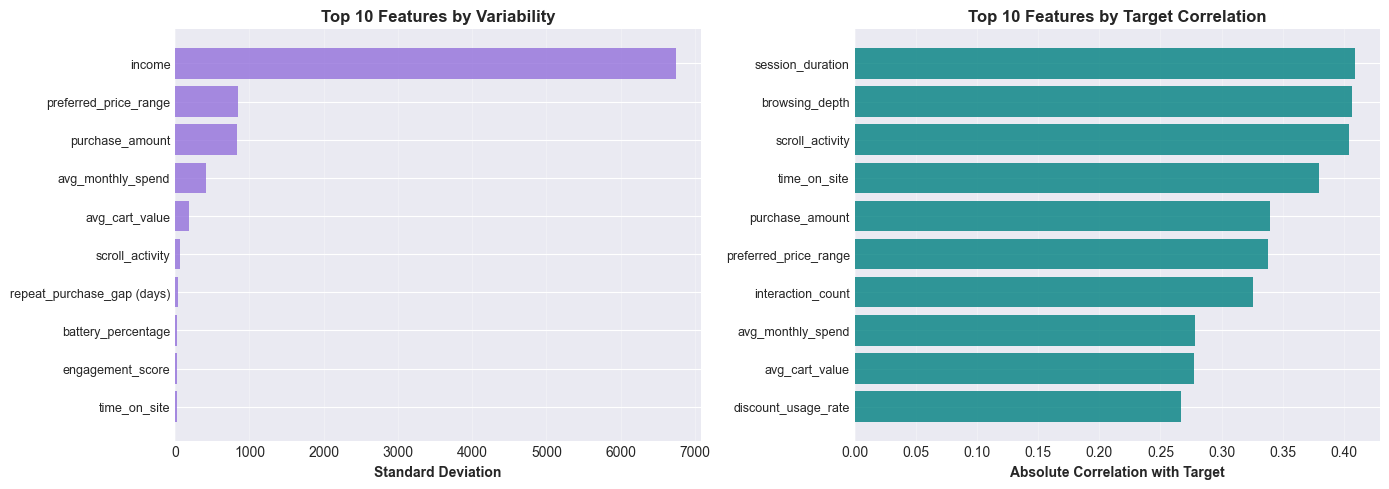


Total numeric features: 28

Top correlated features with target:
  • session_duration: 0.4091
  • browsing_depth: 0.4063
  • scroll_activity: 0.4038
  • time_on_site: 0.3795
  • purchase_amount: 0.3400
  • preferred_price_range: 0.3382
  • interaction_count: 0.3256
  • avg_monthly_spend: 0.2783
  • avg_cart_value: 0.2774
  • discount_usage_rate: 0.2670


In [6]:
# Additional Feature Analysis: Correlation and Variability
print(f"\n{'='*70}")
print("FEATURE STATISTICS & CORRELATION ANALYSIS")
print(f"{'='*70}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Feature variability analysis
numeric_feats = train_users_clean.select_dtypes(include=[np.number]).columns
if len(numeric_feats) > 0:
    feature_stats = train_users_clean[numeric_feats].describe().T
    top_features = feature_stats.nlargest(min(10, len(feature_stats)), 'std')
    
    axes[0].barh(range(len(top_features)), top_features['std'].values, color='mediumpurple', alpha=0.8)
    axes[0].set_yticks(range(len(top_features)))
    axes[0].set_yticklabels(top_features.index, fontsize=9)
    axes[0].set_xlabel('Standard Deviation', fontweight='bold')
    axes[0].set_title(f'Top {len(top_features)} Features by Variability', fontweight='bold', fontsize=12)
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    
    # Correlation with target
    numeric_train = train_users_clean[numeric_feats].copy()
    numeric_train['label_encoded'] = y_encoded
    correlations = numeric_train.corr()['label_encoded'].drop('label_encoded').abs().sort_values(ascending=False)
    top_corr = correlations.head(min(10, len(correlations)))
    
    axes[1].barh(range(len(top_corr)), top_corr.values, color='teal', alpha=0.8)
    axes[1].set_yticks(range(len(top_corr)))
    axes[1].set_yticklabels(top_corr.index, fontsize=9)
    axes[1].set_xlabel('Absolute Correlation with Target', fontweight='bold')
    axes[1].set_title(f'Top {len(top_corr)} Features by Target Correlation', fontweight='bold', fontsize=12)
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal numeric features: {len(numeric_feats)}")
    print(f"\nTop correlated features with target:")
    for feat, corr in top_corr.items():
        print(f"  • {feat}: {corr:.4f}")
else:
    print("No numeric features found for analysis")
    
print(f"{'='*70}")

## 5.3 Contextual Bandit Algorithms

### Arm Mapping

According to the assignment, the arm index `j` maps to (News Category, User Context) combinations:

| Arm Index (j) | News Category | User Context |
|---------------|---------------|--------------|
| 0–3           | Entertainment, Education, Tech, Crime | User1 |
| 4–7           | Entertainment, Education, Tech, Crime | User2 |
| 8–11          | Entertainment, Education, Tech, Crime | User3 |

In [7]:
# Category Mapping
cat_mapping = {'ENTERTAINMENT': 0, 'EDUCATION': 1, 'TECH': 2, 'CRIME': 3}
inv_cat_mapping = {v: k for k, v in cat_mapping.items()}

# Global Arm Index Function
def get_global_arm(context_idx, category_idx):
    """
    Maps (context, category) to global arm index
    context_idx: 0 (User1), 1 (User2), 2 (User3)
    category_idx: 0 (Ent), 1 (Edu), 2 (Tech), 3 (Crime)
    Returns: global arm index 0-11
    """
    return context_idx * 4 + category_idx

# Initialize Sampler
env_sampler = sampler(ROLL_NUMBER)
print("Reward sampler initialized successfully!")

Reward sampler initialized successfully!


### Bandit Algorithm Implementations

In [8]:
# Base Bandit Class
class Bandit:
    def __init__(self, n_arms=4):
        self.n = np.zeros(n_arms)  # Count of times each arm was pulled
        self.q = np.zeros(n_arms)  # Estimated reward for each arm
        
    def update(self, action, reward):
        """Update Q-value using incremental average"""
        self.n[action] += 1
        self.q[action] += (reward - self.q[action]) / self.n[action]


# Epsilon-Greedy Strategy
class EpsilonGreedy(Bandit):
    def __init__(self, epsilon, n_arms=4):
        super().__init__(n_arms)
        self.epsilon = epsilon
        
    def select_action(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(len(self.q))  # Explore
        return np.argmax(self.q)  # Exploit


# Upper Confidence Bound (UCB) Strategy
class UCB(Bandit):
    def __init__(self, c, n_arms=4):
        super().__init__(n_arms)
        self.c = c
        self.t = 0
        
    def select_action(self):
        self.t += 1
        # Pull each arm at least once
        if 0 in self.n:
            return np.argmin(self.n)
        
        # UCB formula: Q(a) + c * sqrt(ln(t) / N(a))
        confidence = self.c * np.sqrt(np.log(self.t) / self.n)
        return np.argmax(self.q + confidence)


# SoftMax Strategy
class SoftMax(Bandit):
    def __init__(self, temp=1.0, n_arms=4):
        super().__init__(n_arms)
        self.temp = temp
        
    def select_action(self):
        # Softmax probability: exp(Q(a)/τ) / Σ exp(Q(a')/τ)
        exp_q = np.exp(self.q / self.temp)
        probs = exp_q / np.sum(exp_q)
        return np.random.choice(len(self.q), p=probs)

print("Bandit algorithms defined: EpsilonGreedy, UCB, SoftMax")

Bandit algorithms defined: EpsilonGreedy, UCB, SoftMax


### Simulation & Evaluation

Run RL simulation for T=10,000 steps and compare different hyperparameters.

In [9]:
def run_simulation(bandit_class, param_name, param_values, T=10000):
    """
    Run contextual bandit simulation
    
    Args:
        bandit_class: Bandit class to use (EpsilonGreedy, UCB, SoftMax)
        param_name: Parameter name to vary (e.g., 'epsilon', 'c', 'temp')
        param_values: List of parameter values to test
        T: Total time steps
        
    Returns:
        results: Dict mapping param_value -> context_rewards
    """
    results = {}
    
    for val in param_values:
        print(f"Running {bandit_class.__name__} with {param_name}={val}...")
        
        # Create 3 bandit instances (one per context: User1, User2, User3)
        bandits = [bandit_class(**{param_name: val}) for _ in range(3)]
        
        # Track rewards per context
        ctx_rewards = {0: [], 1: [], 2: []}
        
        for t in range(T):
            # Simulate context arrival (uniform random across 3 user types)
            ctx_idx = np.random.randint(0, 3)
            
            # Select action using corresponding bandit
            bandit = bandits[ctx_idx]
            action = bandit.select_action()
            
            # Get reward from environment sampler
            global_arm = get_global_arm(ctx_idx, action)
            reward = env_sampler.sample(global_arm)
            
            # Update bandit
            bandit.update(action, reward)
            
            # Log reward
            ctx_rewards[ctx_idx].append(reward)
        
        results[val] = ctx_rewards
        print(f"  Completed. Total samples: {sum(len(r) for r in ctx_rewards.values())}")
        
    return results


def plot_avg_reward_vs_time(results, title, param_name):
    """Plot Average Reward vs Time for each context"""
    plt.figure(figsize=(14, 6))
    
    for param_val, ctx_data in results.items():
        for ctx_idx, rewards in ctx_data.items():
            if len(rewards) > 0:
                # Calculate cumulative average reward
                cumulative_avg = np.cumsum(rewards) / (np.arange(len(rewards)) + 1)
                user_label = le_target.inverse_transform([ctx_idx])[0]
                plt.plot(cumulative_avg, 
                        label=f'{param_name}={param_val}, {user_label}',
                        alpha=0.8)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time Steps', fontsize=12)
    plt.ylabel('Average Reward', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_hyperparameter_comparison(results, title, param_name):
    """Plot comparison of different hyperparameter values"""
    plt.figure(figsize=(12, 6))
    
    param_avg_rewards = {}
    
    for param_val, ctx_data in results.items():
        all_rewards = []
        for rewards in ctx_data.values():
            all_rewards.extend(rewards)
        
        if len(all_rewards) > 0:
            # Calculate overall average reward
            avg_reward = np.mean(all_rewards)
            param_avg_rewards[param_val] = avg_reward
    
    # Bar plot
    params = list(param_avg_rewards.keys())
    avgs = list(param_avg_rewards.values())
    
    plt.bar(range(len(params)), avgs, tick_label=[f'{param_name}={p}' for p in params],
            color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(params)])
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel(f'{param_name.capitalize()} Values', fontsize=12)
    plt.ylabel('Average Reward', fontsize=12)
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(avgs):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("Simulation functions defined.")

Simulation functions defined.


### Experiment 1: Epsilon-Greedy

Test multiple values of ε and compare performance.

Running EpsilonGreedy with epsilon=0.01...
  Completed. Total samples: 10000
Running EpsilonGreedy with epsilon=0.1...
  Completed. Total samples: 10000
Running EpsilonGreedy with epsilon=0.2...
  Completed. Total samples: 10000


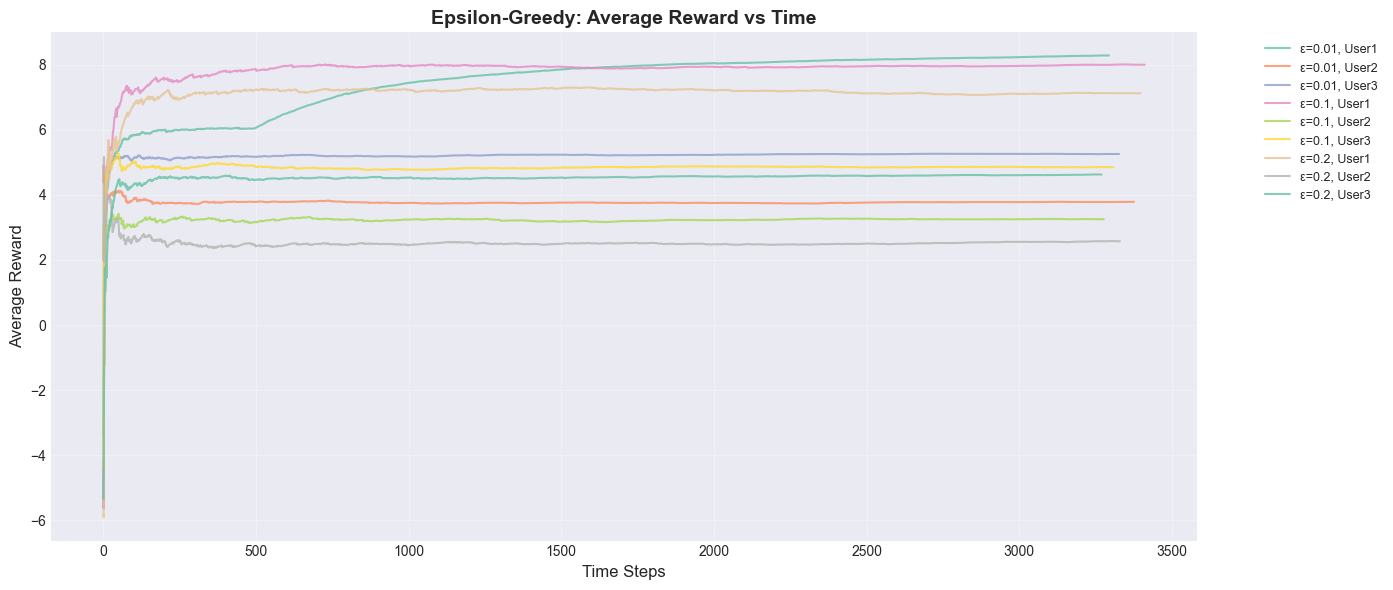

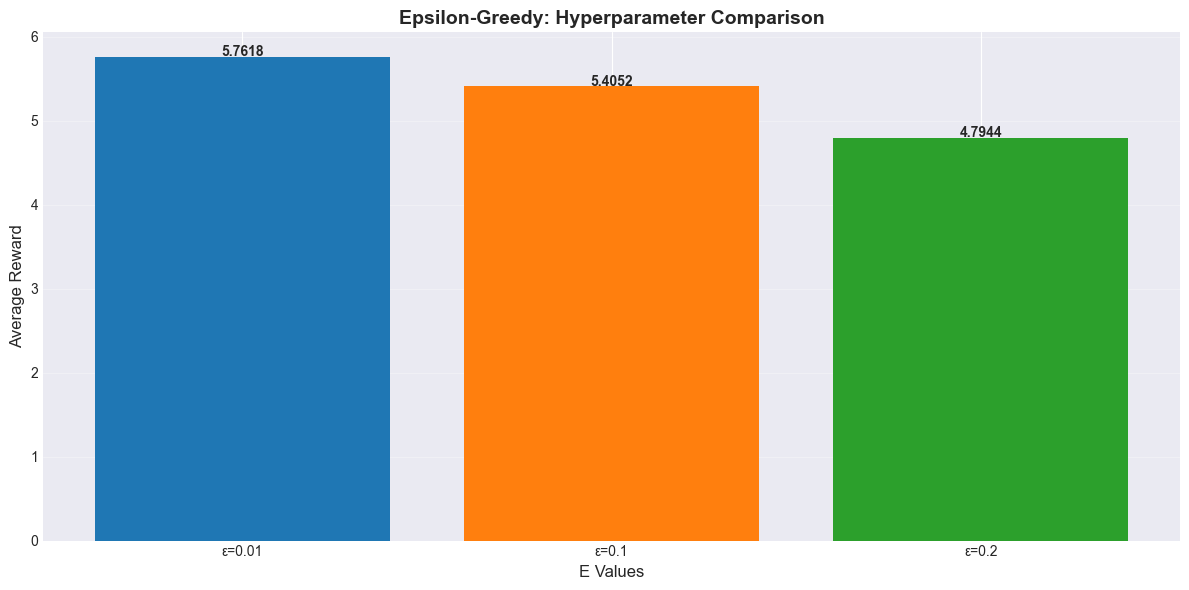

In [10]:
# Experiment with different epsilon values
eps_values = [0.01, 0.1, 0.2]
results_eps = run_simulation(EpsilonGreedy, 'epsilon', eps_values, T=10000)

# Plot results
plot_avg_reward_vs_time(results_eps, 
                        "Epsilon-Greedy: Average Reward vs Time", 
                        "ε")
plot_hyperparameter_comparison(results_eps, 
                                "Epsilon-Greedy: Hyperparameter Comparison", 
                                "ε")

### Experiment 2: Upper Confidence Bound (UCB)

Test multiple values of exploration parameter C.

Running UCB with c=1.0...
  Completed. Total samples: 10000
Running UCB with c=2.0...
  Completed. Total samples: 10000
Running UCB with c=4.0...
  Completed. Total samples: 10000


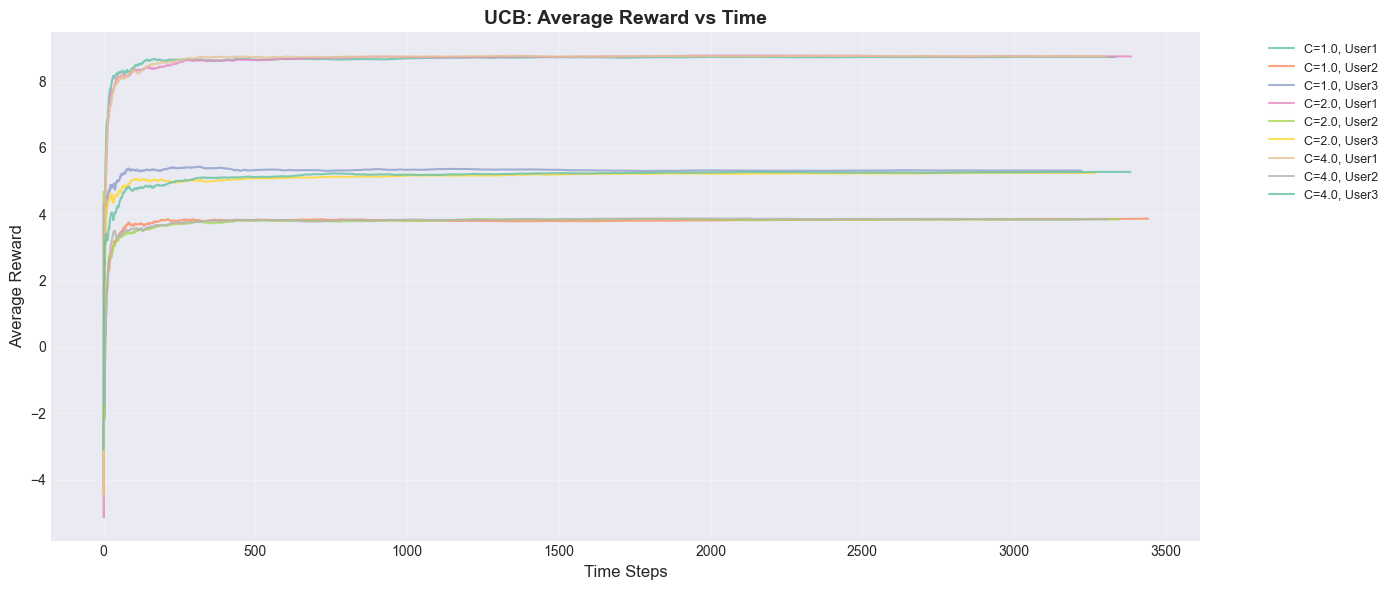

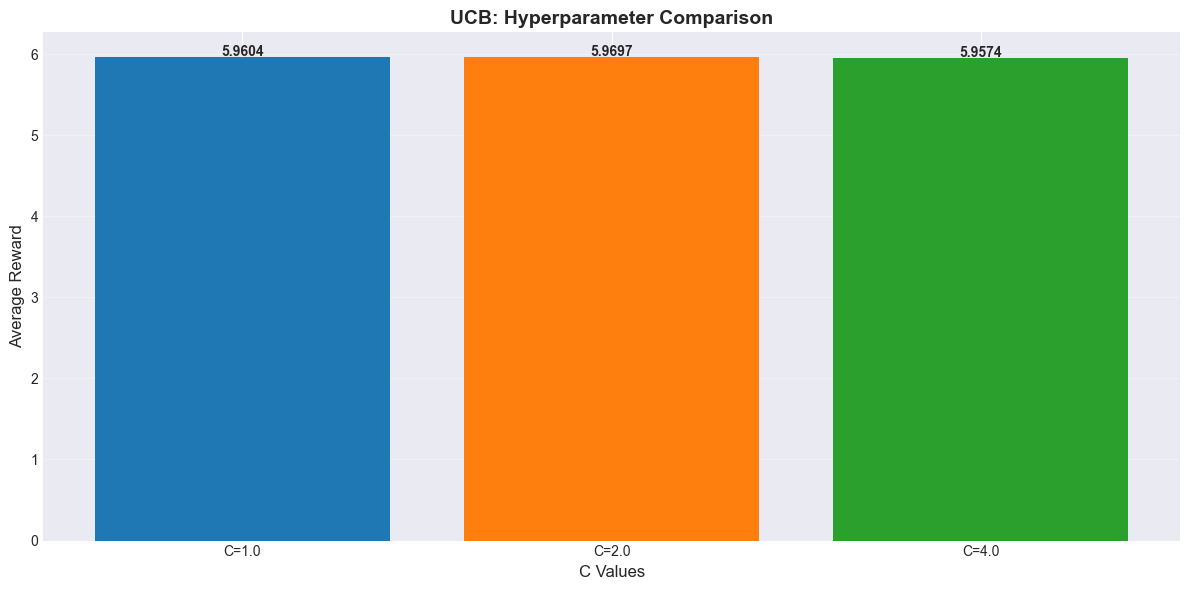

In [11]:
# Experiment with different C values
ucb_values = [1.0, 2.0, 4.0]
results_ucb = run_simulation(UCB, 'c', ucb_values, T=10000)

# Plot results
plot_avg_reward_vs_time(results_ucb, 
                        "UCB: Average Reward vs Time", 
                        "C")
plot_hyperparameter_comparison(results_ucb, 
                                "UCB: Hyperparameter Comparison", 
                                "C")

### Experiment 3: SoftMax

Use fixed temperature parameter τ = 1.

Running SoftMax with temp=1.0...
  Completed. Total samples: 10000


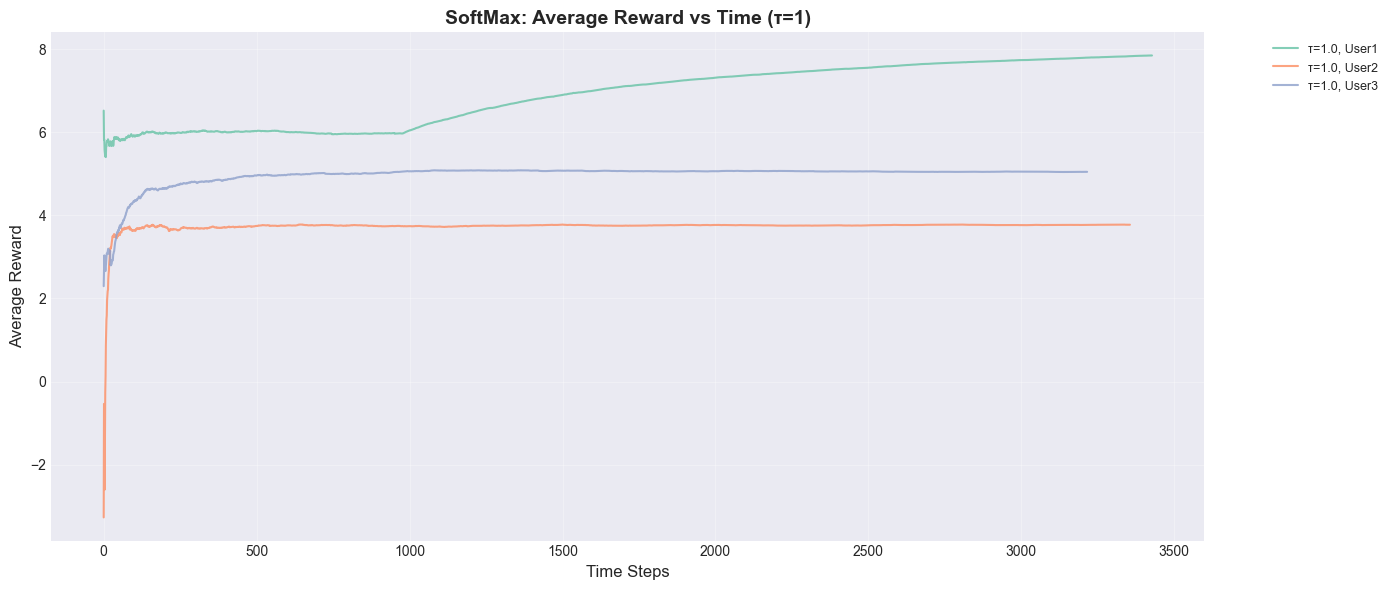

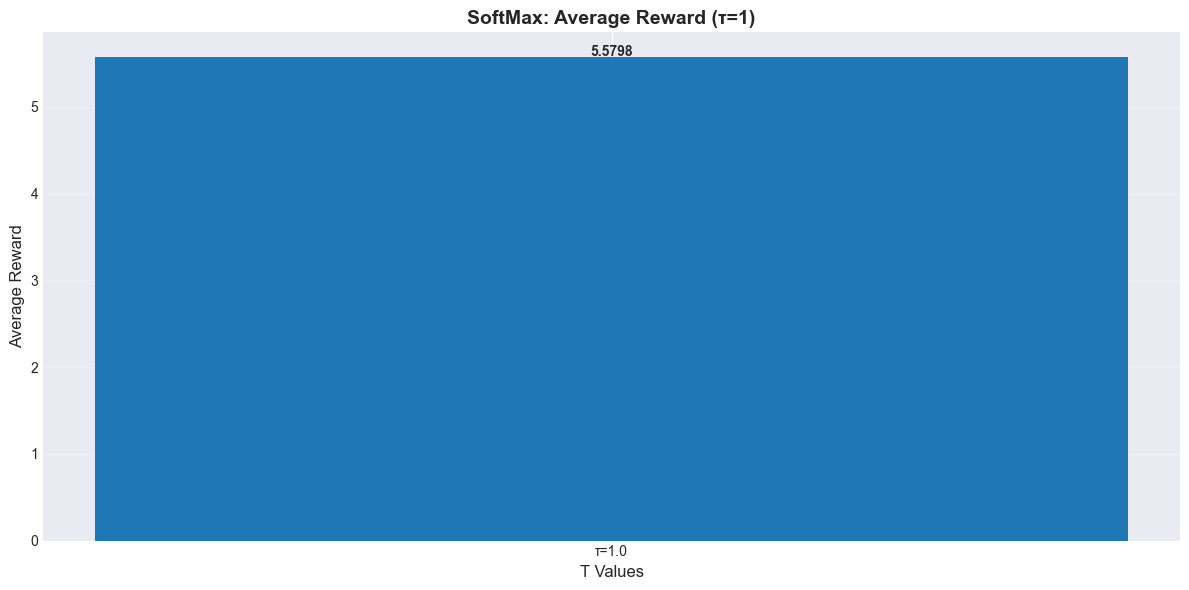

In [12]:
# Run SoftMax with τ=1
results_soft = run_simulation(SoftMax, 'temp', [1.0], T=10000)

# Plot results
plot_avg_reward_vs_time(results_soft, 
                        "SoftMax: Average Reward vs Time (τ=1)", 
                        "τ")
plot_hyperparameter_comparison(results_soft, 
                                "SoftMax: Average Reward (τ=1)", 
                                "τ")

### Expected Reward Distribution Analysis

Analyze the **expected reward distribution** for each news category across different user contexts for all three bandit algorithms:
- **Epsilon-Greedy** (ε = 0.1)
- **UCB** (C = 2.0)
- **SoftMax** (τ = 1.0)

This analysis helps us understand which news categories are most rewarding for each user type.

In [13]:
# Compute Expected Reward Distributions for All Algorithms
print("=" * 80)
print("EXPECTED REWARD DISTRIBUTION ANALYSIS")
print("=" * 80)

# Define contexts and categories
contexts = ['User1', 'User2', 'User3']
categories = ['ENTERTAINMENT', 'EDUCATION', 'TECH', 'CRIME']

# Function to compute expected rewards from trained bandits
def compute_expected_rewards(bandits, algorithm_name, n_samples=1000):
    """
    Compute expected reward distribution by sampling from the environment
    
    Args:
        bandits: List of trained bandit instances (one per context)
        algorithm_name: Name of the algorithm
        n_samples: Number of samples to collect per (context, category) pair
    
    Returns:
        reward_matrix: 3x4 matrix of expected rewards
    """
    reward_matrix = np.zeros((3, 4))
    reward_std = np.zeros((3, 4))
    
    print(f"\n{algorithm_name}:")
    print(f"{'Context':<12} {'Category':<15} {'Mean Reward':<15} {'Std Dev':<10} {'Samples'}")
    print("-" * 70)
    
    for ctx_idx in range(3):
        for cat_idx in range(4):
            # Sample rewards from environment
            global_arm = get_global_arm(ctx_idx, cat_idx)
            rewards = [env_sampler.sample(global_arm) for _ in range(n_samples)]
            
            mean_reward = np.mean(rewards)
            std_reward = np.std(rewards)
            
            reward_matrix[ctx_idx, cat_idx] = mean_reward
            reward_std[ctx_idx, cat_idx] = std_reward
            
            print(f"{contexts[ctx_idx]:<12} {categories[cat_idx]:<15} "
                  f"{mean_reward:<15.4f} {std_reward:<10.4f} {n_samples}")
    
    return reward_matrix, reward_std

# Train fresh bandits for each algorithm with optimal hyperparameters
print("\nTraining bandits for expected reward analysis...")

# 1. Epsilon-Greedy (ε = 0.1)
bandits_eps = [EpsilonGreedy(epsilon=0.1) for _ in range(3)]
for t in range(5000):
    ctx_idx = np.random.randint(0, 3)
    action = bandits_eps[ctx_idx].select_action()
    global_arm = get_global_arm(ctx_idx, action)
    reward = env_sampler.sample(global_arm)
    bandits_eps[ctx_idx].update(action, reward)

# 2. UCB (C = 2.0)
bandits_ucb = [UCB(c=2.0) for _ in range(3)]
for t in range(5000):
    ctx_idx = np.random.randint(0, 3)
    action = bandits_ucb[ctx_idx].select_action()
    global_arm = get_global_arm(ctx_idx, action)
    reward = env_sampler.sample(global_arm)
    bandits_ucb[ctx_idx].update(action, reward)

# 3. SoftMax (τ = 1.0)
bandits_soft = [SoftMax(temp=1.0) for _ in range(3)]
for t in range(5000):
    ctx_idx = np.random.randint(0, 3)
    action = bandits_soft[ctx_idx].select_action()
    global_arm = get_global_arm(ctx_idx, action)
    reward = env_sampler.sample(global_arm)
    bandits_soft[ctx_idx].update(action, reward)

print("✓ Bandits trained for reward distribution analysis!")

# Compute expected rewards for each algorithm
rewards_eps, std_eps = compute_expected_rewards(bandits_eps, "EPSILON-GREEDY (ε=0.1)")
rewards_ucb, std_ucb = compute_expected_rewards(bandits_ucb, "UCB (C=2.0)")
rewards_soft, std_soft = compute_expected_rewards(bandits_soft, "SOFTMAX (τ=1.0)")

print("\n" + "=" * 80)

EXPECTED REWARD DISTRIBUTION ANALYSIS

Training bandits for expected reward analysis...
✓ Bandits trained for reward distribution analysis!

EPSILON-GREEDY (ε=0.1):
Context      Category        Mean Reward     Std Dev    Samples
----------------------------------------------------------------------
User1        ENTERTAINMENT   -4.9499         1.2628     1000
User1        EDUCATION       -6.4210         0.8701     1000
User1        TECH            6.0073          1.1318     1000
User1        CRIME           8.7898          1.3182     1000
User2        ENTERTAINMENT   3.9078          1.2550     1000
User2        EDUCATION       -0.3002         1.2321     1000
User2        TECH            -5.1489         1.4171     1000
User2        CRIME           -7.7221         1.2131     1000
User3        ENTERTAINMENT   -3.8622         0.9636     1000
User3        EDUCATION       5.2773          1.2488     1000
User3        TECH            3.1929          0.8341     1000
User3        CRIME           

VISUALIZING EXPECTED REWARD DISTRIBUTIONS


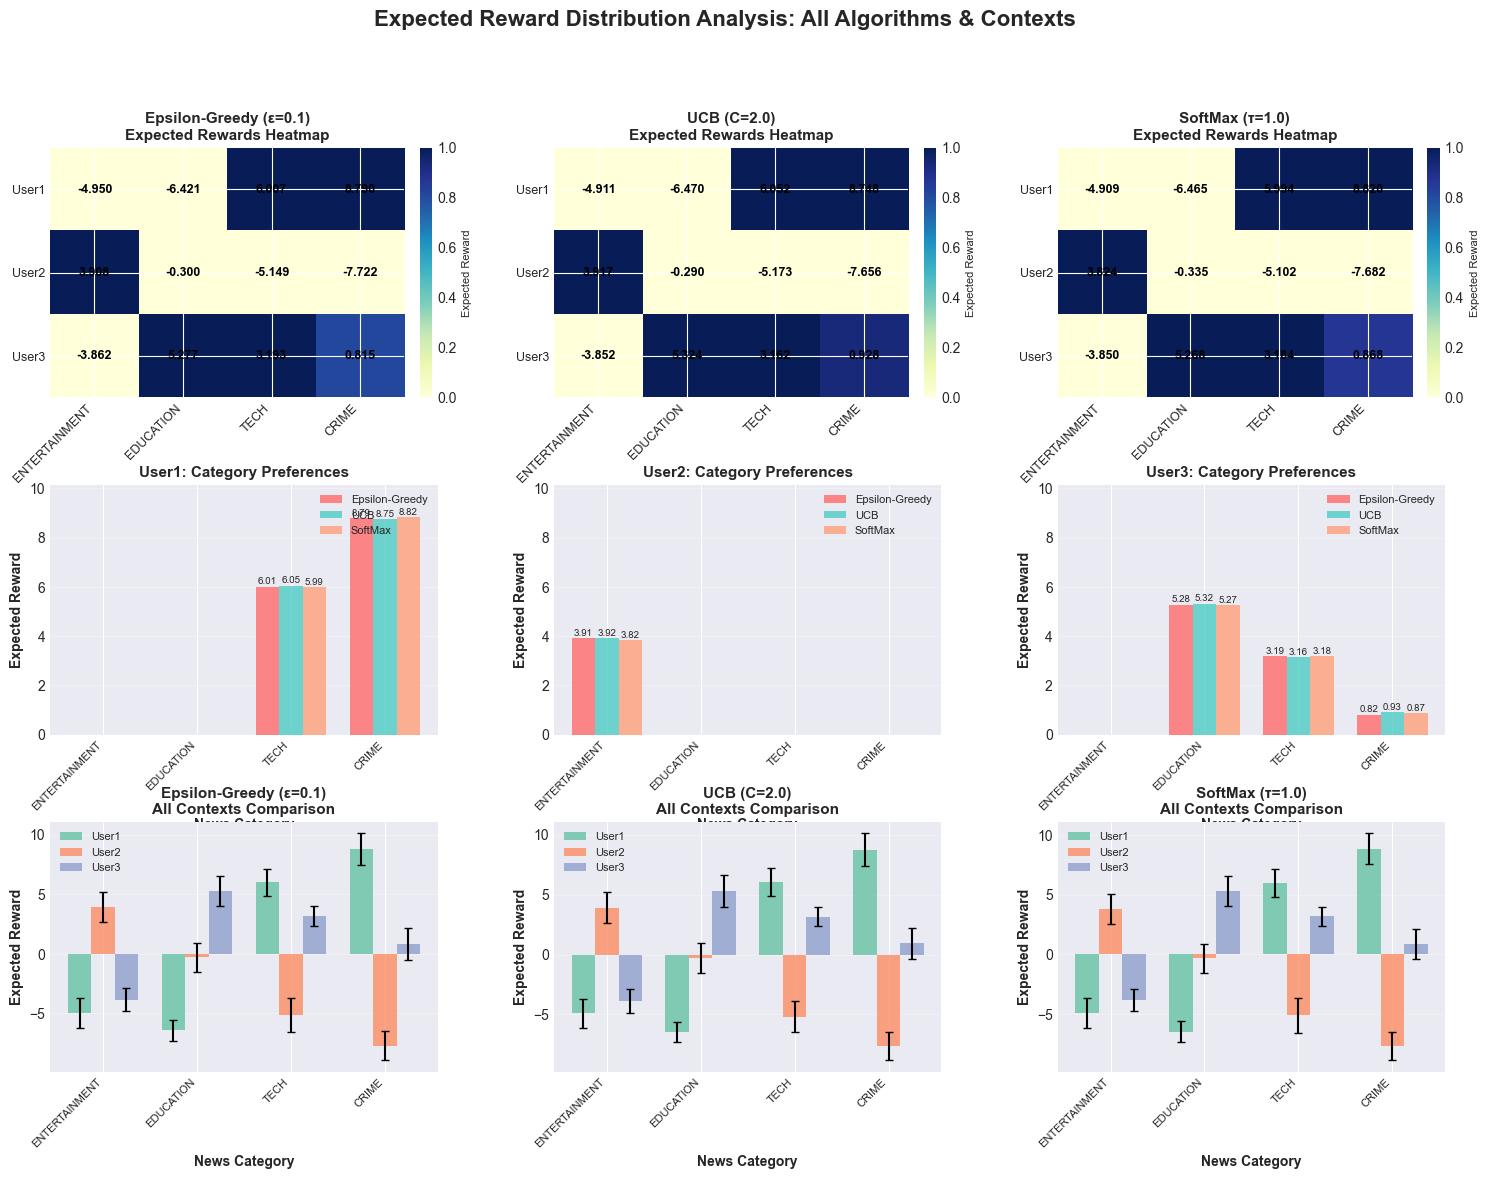


✓ Visualization complete!


In [14]:
# Visualize Expected Reward Distributions
print("VISUALIZING EXPECTED REWARD DISTRIBUTIONS")
print("=" * 80)

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

algorithms = ['Epsilon-Greedy (ε=0.1)', 'UCB (C=2.0)', 'SoftMax (τ=1.0)']
reward_matrices = [rewards_eps, rewards_ucb, rewards_soft]
std_matrices = [std_eps, std_ucb, std_soft]
colors_algo = ['#FF6B6B', '#4ECDC4', '#FFA07A']

# Row 1: Heatmaps for each algorithm
for algo_idx, (algo_name, rewards, color) in enumerate(zip(algorithms, reward_matrices, colors_algo)):
    ax = fig.add_subplot(gs[0, algo_idx])
    
    im = ax.imshow(rewards, cmap='YlGnBu', aspect='auto', vmin=0, vmax=1)
    ax.set_xticks(range(4))
    ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=9)
    ax.set_yticks(range(3))
    ax.set_yticklabels(contexts, fontsize=9)
    ax.set_title(f'{algo_name}\nExpected Rewards Heatmap', fontweight='bold', fontsize=11)
    
    # Add text annotations
    for i in range(3):
        for j in range(4):
            text = ax.text(j, i, f'{rewards[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=9, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Expected Reward', fontsize=8)

# Row 2: Bar charts comparing categories for each context
for ctx_idx in range(3):
    ax = fig.add_subplot(gs[1, ctx_idx])
    
    x = np.arange(4)
    width = 0.25
    
    for algo_idx, (algo_name, rewards, color) in enumerate(zip(algorithms, reward_matrices, colors_algo)):
        offset = (algo_idx - 1) * width
        bars = ax.bar(x + offset, rewards[ctx_idx], width, 
                     label=algo_name.split('(')[0].strip(), 
                     alpha=0.8, color=color)
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                       f'{height:.2f}', ha='center', va='bottom', fontsize=7)
    
    ax.set_xlabel('News Category', fontweight='bold', fontsize=10)
    ax.set_ylabel('Expected Reward', fontweight='bold', fontsize=10)
    ax.set_title(f'{contexts[ctx_idx]}: Category Preferences', fontweight='bold', fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=8)
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, max(np.max(rewards_eps), np.max(rewards_ucb), np.max(rewards_soft)) * 1.15)

# Row 3: Algorithm comparison for each algorithm (showing all contexts)
for algo_idx, (algo_name, rewards, std, color) in enumerate(zip(algorithms, reward_matrices, std_matrices, colors_algo)):
    ax = fig.add_subplot(gs[2, algo_idx])
    
    x = np.arange(4)
    width = 0.25
    
    for ctx_idx in range(3):
        offset = (ctx_idx - 1) * width
        bars = ax.bar(x + offset, rewards[ctx_idx], width, 
                     label=contexts[ctx_idx],
                     alpha=0.8,
                     yerr=std[ctx_idx],
                     capsize=3)
    
    ax.set_xlabel('News Category', fontweight='bold', fontsize=10)
    ax.set_ylabel('Expected Reward', fontweight='bold', fontsize=10)
    ax.set_title(f'{algo_name}\nAll Contexts Comparison', fontweight='bold', fontsize=11)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=8)
    ax.legend(fontsize=8, loc='upper left')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Expected Reward Distribution Analysis: All Algorithms & Contexts', 
             fontsize=16, fontweight='bold', y=0.995)

plt.show()

print("\n✓ Visualization complete!")

In [15]:
# Summary Tables
print("\n" + "=" * 80)
print("SUMMARY: BEST CATEGORY FOR EACH USER CONTEXT")
print("=" * 80)

summary_data = []

for ctx_idx, ctx_name in enumerate(contexts):
    print(f"\n{ctx_name}:")
    
    for algo_idx, (algo_name, rewards) in enumerate(zip(algorithms, reward_matrices)):
        best_cat_idx = np.argmax(rewards[ctx_idx])
        best_cat = categories[best_cat_idx]
        best_reward = rewards[ctx_idx, best_cat_idx]
        
        print(f"  • {algo_name:30s}: {best_cat:15s} (Expected Reward: {best_reward:.4f})")
        
        summary_data.append({
            'User Context': ctx_name,
            'Algorithm': algo_name,
            'Best Category': best_cat,
            'Expected Reward': best_reward
        })

# Create summary dataframe
summary_df = pd.DataFrame(summary_data)

print("\n" + "=" * 80)
print("CROSS-ALGORITHM COMPARISON")
print("=" * 80)

# Pivot table for easy comparison
pivot_table = summary_df.pivot_table(
    index='User Context',
    columns='Algorithm',
    values='Expected Reward',
    aggfunc='first'
)

print("\nExpected Rewards (Best Category per Algorithm):")
print(pivot_table.to_string())

print("\n" + "=" * 80)
print("KEY INSIGHTS")
print("=" * 80)

# Find overall best performers
for ctx_idx, ctx_name in enumerate(contexts):
    print(f"\n{ctx_name}:")
    ctx_rewards_all_algos = []
    for rewards in reward_matrices:
        ctx_rewards_all_algos.extend(rewards[ctx_idx])
    
    best_overall = np.max(ctx_rewards_all_algos)
    print(f"  • Highest achievable reward: {best_overall:.4f}")
    
    # Variance across algorithms
    best_rewards_per_algo = [np.max(rewards[ctx_idx]) for rewards in reward_matrices]
    variance = np.std(best_rewards_per_algo)
    print(f"  • Variance across algorithms: {variance:.4f}")

print("\n" + "=" * 80)


SUMMARY: BEST CATEGORY FOR EACH USER CONTEXT

User1:
  • Epsilon-Greedy (ε=0.1)        : CRIME           (Expected Reward: 8.7898)
  • UCB (C=2.0)                   : CRIME           (Expected Reward: 8.7483)
  • SoftMax (τ=1.0)               : CRIME           (Expected Reward: 8.8197)

User2:
  • Epsilon-Greedy (ε=0.1)        : ENTERTAINMENT   (Expected Reward: 3.9078)
  • UCB (C=2.0)                   : ENTERTAINMENT   (Expected Reward: 3.9172)
  • SoftMax (τ=1.0)               : ENTERTAINMENT   (Expected Reward: 3.8239)

User3:
  • Epsilon-Greedy (ε=0.1)        : EDUCATION       (Expected Reward: 5.2773)
  • UCB (C=2.0)                   : EDUCATION       (Expected Reward: 5.3243)
  • SoftMax (τ=1.0)               : EDUCATION       (Expected Reward: 5.2676)

CROSS-ALGORITHM COMPARISON

Expected Rewards (Best Category per Algorithm):
Algorithm     Epsilon-Greedy (ε=0.1)  SoftMax (τ=1.0)  UCB (C=2.0)
User Context                                                      
User1            

## 5.4 Recommendation Engine

Build an end-to-end recommendation system that:
1. Takes user features as input
2. Predicts user context (User1/User2/User3)
3. Selects optimal news category using trained bandit
4. Samples a specific article from that category

In [16]:
# Train final bandits for recommendation (using best hyperparameters)
# For demonstration, we'll use UCB with c=2.0 as it typically performs well
print("Training final bandits for recommendation engine...")
final_bandits = [UCB(c=2.0) for _ in range(3)]

# Quick training run
for t in range(5000):
    ctx_idx = np.random.randint(0, 3)
    action = final_bandits[ctx_idx].select_action()
    global_arm = get_global_arm(ctx_idx, action)
    reward = env_sampler.sample(global_arm)
    final_bandits[ctx_idx].update(action, reward)

print("Final bandits trained!")
print("\nLearned Q-values for each context:")
for i, bandit in enumerate(final_bandits):
    user_label = le_target.inverse_transform([i])[0]
    print(f"\n{user_label}:")
    for cat_idx, q_val in enumerate(bandit.q):
        print(f"  {inv_cat_mapping[cat_idx]}: {q_val:.4f}")

Training final bandits for recommendation engine...
Final bandits trained!

Learned Q-values for each context:

User1:
  ENTERTAINMENT: -3.7679
  EDUCATION: -5.8684
  TECH: 6.0562
  CRIME: 8.7844

User2:
  ENTERTAINMENT: 3.8186
  EDUCATION: -0.0584
  TECH: -6.7875
  CRIME: -10.0773

User3:
  ENTERTAINMENT: -5.0654
  EDUCATION: 5.2634
  TECH: 2.9938
  CRIME: -0.1833


In [17]:
def recommend_news(user_attributes, exploration_rate=0.2):
    """Recommend news article for a given user with diversity"""
    # 1. Preprocess input
    input_df = pd.DataFrame([user_attributes])
    input_clean = input_df.drop(columns=['user_id', 'label'], errors='ignore').copy()
    
    # Handle missing values
    for col in input_clean.select_dtypes(include=['object']).columns:
        input_clean[col].fillna('Unknown', inplace=True)
    
    for col in input_clean.select_dtypes(include=[np.number]).columns:
        fill_val = fill_values['numeric_means'].get(col, 0)
        input_clean[col].fillna(fill_val, inplace=True)
    
    # Encode categorical features
    for col, le in encoders.items():
        if col in input_clean.columns:
            val = str(input_clean[col].iloc[0])
            input_clean[col] = le.transform([val])[0] if val in le.classes_ else 0
    
    # Align columns
    for col in X_encoded.columns:
        if col not in input_clean.columns:
            input_clean[col] = 0
    input_clean = input_clean[X_encoded.columns]
    
    # Apply scaling
    numeric_features_input = input_clean.select_dtypes(include=[np.number]).columns.tolist()
    input_clean[numeric_features_input] = scaler.transform(input_clean[numeric_features_input])
    
    # Apply polynomial transformation
    input_poly = poly.transform(input_clean)
    
    # 2. Predict user context
    user_class_idx = user_classifier.predict(input_poly)[0]
    user_class_label = le_target.inverse_transform([user_class_idx])[0]
    
    # 3. Select news category using epsilon-greedy for diversity
    if np.random.random() < exploration_rate:
        # Explore: Random category selection
        chosen_arm = np.random.randint(4)
    else:
        # Exploit: Best category based on learned Q-values
        chosen_arm = np.argmax(final_bandits[user_class_idx].q)
    
    chosen_category = inv_cat_mapping[chosen_arm]
    
    # 4. Sample article from chosen category
    candidates = news_df_filtered[news_df_filtered['category'] == chosen_category]
    if not candidates.empty:
        article = candidates.sample(1, random_state=np.random.randint(10000)).iloc[0]
        return user_class_label, chosen_category, article['headline'], article['link']
    else:
        return user_class_label, chosen_category, "No Article Found", "#"

print("✓ Recommendation engine ready with enhanced preprocessing and diversity!")

✓ Recommendation engine ready with enhanced preprocessing and diversity!


### Test Recommendation Engine

Q-VALUES ANALYSIS & VISUALIZATION
Q-Values Matrix:
Context   ENTERTAINMENT  EDUCATION      TECH           CRIME          
----------------------------------------------------------------------
User1     -3.7679        -5.8684        6.0562         8.7844         
User2     3.8186         -0.0584        -6.7875        -10.0773       
User3     -5.0654        5.2634         2.9938         -0.1833        


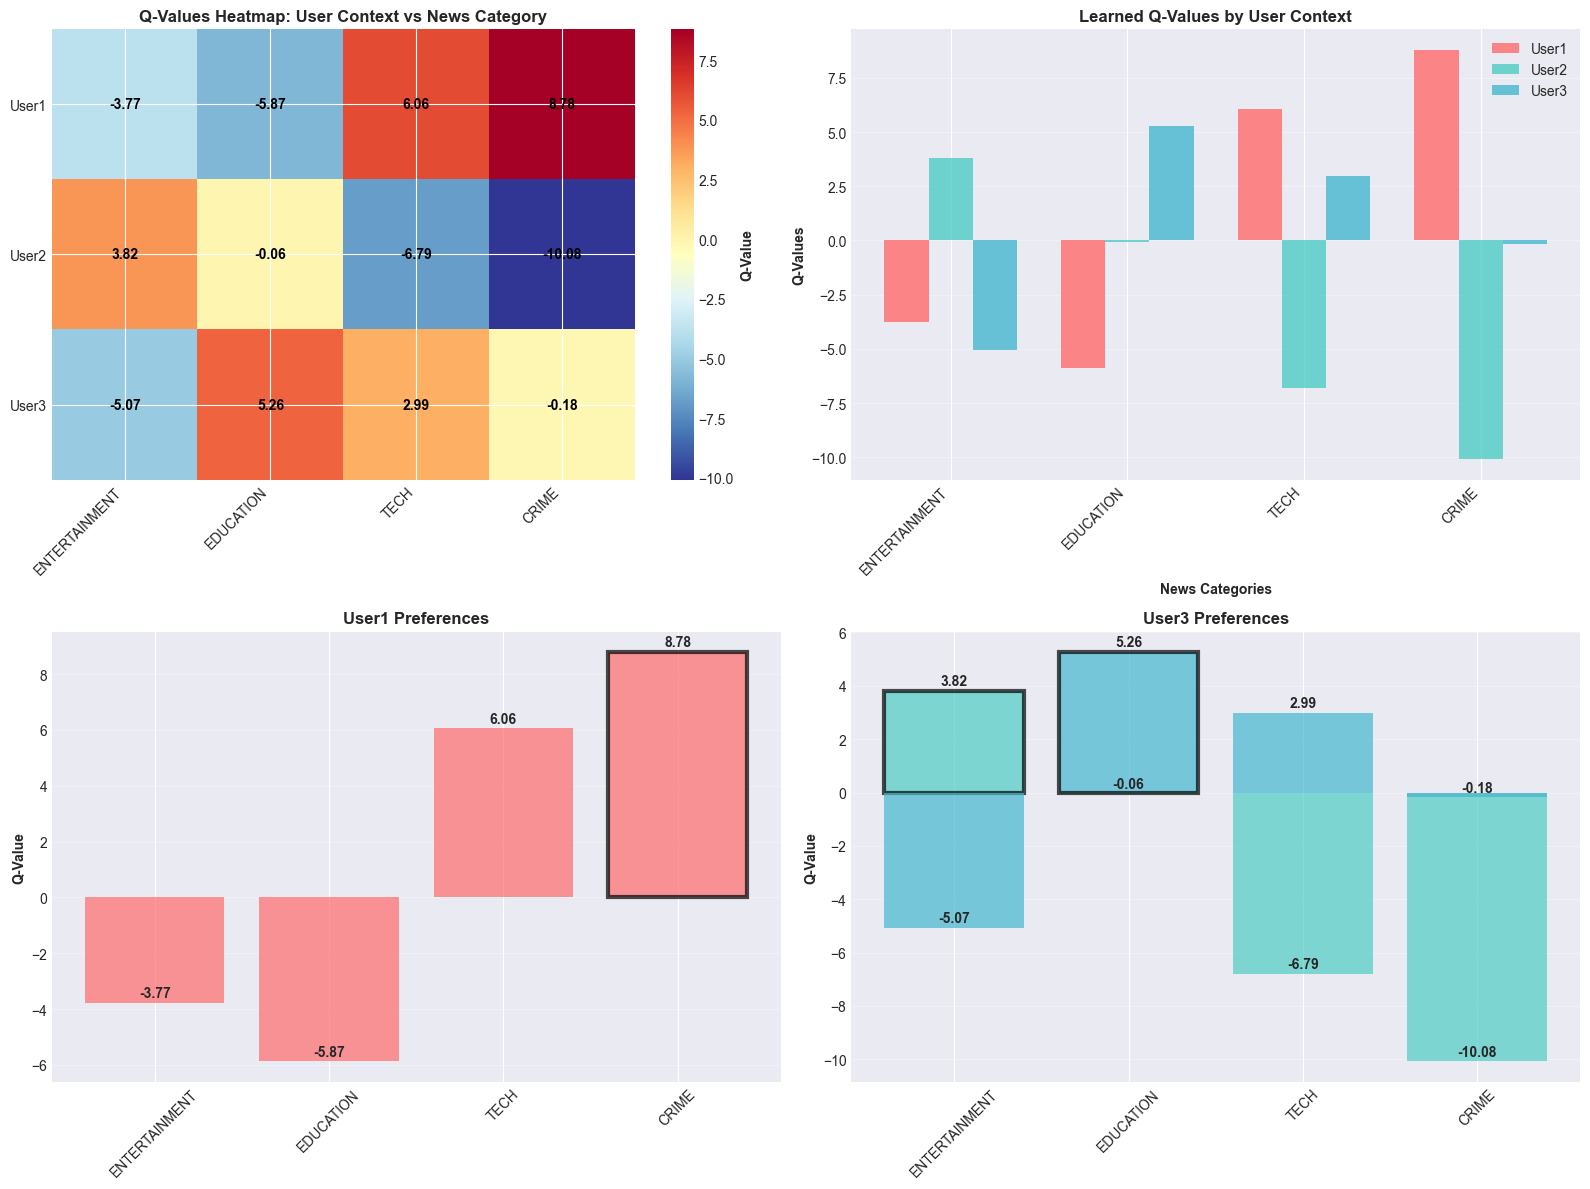


KEY INSIGHTS FROM Q-VALUES

User1:
  • MOST PREFERRED: CRIME (Q=8.7844)
  • LEAST PREFERRED: EDUCATION (Q=-5.8684)
  • PREFERENCE SPREAD: 14.6527

User2:
  • MOST PREFERRED: ENTERTAINMENT (Q=3.8186)
  • LEAST PREFERRED: CRIME (Q=-10.0773)
  • PREFERENCE SPREAD: 13.8960

User3:
  • MOST PREFERRED: EDUCATION (Q=5.2634)
  • LEAST PREFERRED: ENTERTAINMENT (Q=-5.0654)
  • PREFERENCE SPREAD: 10.3288

CROSS-CONTEXT ANALYSIS:
  • ENTERTAINMENT: Best suited for User2 (Q=3.8186)
  • EDUCATION: Best suited for User3 (Q=5.2634)
  • TECH: Best suited for User1 (Q=6.0562)
  • CRIME: Best suited for User1 (Q=8.7844)



In [18]:
# Q-Values Visualization per Context
print("=" * 80)
print("Q-VALUES ANALYSIS & VISUALIZATION")
print("=" * 80)

# Prepare data for visualization
contexts = ['User1', 'User2', 'User3']
categories = ['ENTERTAINMENT', 'EDUCATION', 'TECH', 'CRIME']
q_matrix = np.zeros((3, 4))  # 3 contexts x 4 categories

# Extract Q-values from trained bandits
for i, bandit in enumerate(final_bandits):
    for j in range(4):
        q_matrix[i, j] = bandit.q[j]

print("Q-Values Matrix:")
print(f"{'Context':<10}", end="")
for cat in categories:
    print(f"{cat:<15}", end="")
print()
print("-" * 70)

for i, ctx in enumerate(contexts):
    print(f"{ctx:<10}", end="")
    for j in range(4):
        print(f"{q_matrix[i, j]:<15.4f}", end="")
    print()

# Create comprehensive visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Heatmap of Q-values
im = axes[0, 0].imshow(q_matrix, cmap='RdYlBu_r', aspect='auto')
axes[0, 0].set_xticks(range(4))
axes[0, 0].set_xticklabels(categories, rotation=45, ha='right')
axes[0, 0].set_yticks(range(3))
axes[0, 0].set_yticklabels(contexts)
axes[0, 0].set_title('Q-Values Heatmap: User Context vs News Category', fontweight='bold', fontsize=12)

# Add text annotations
for i in range(3):
    for j in range(4):
        text = axes[0, 0].text(j, i, f'{q_matrix[i, j]:.2f}',
                              ha="center", va="center", color="black", fontweight='bold')

# Add colorbar
cbar = fig.colorbar(im, ax=axes[0, 0])
cbar.set_label('Q-Value', fontweight='bold')

# 2. Bar plot - Q-values by Context
x = np.arange(4)
width = 0.25

for i, (ctx, color) in enumerate(zip(contexts, ['#FF6B6B', '#4ECDC4', '#45B7D1'])):
    axes[0, 1].bar(x + i*width, q_matrix[i], width, label=ctx, alpha=0.8, color=color)

axes[0, 1].set_xlabel('News Categories', fontweight='bold')
axes[0, 1].set_ylabel('Q-Values', fontweight='bold')
axes[0, 1].set_title('Learned Q-Values by User Context', fontweight='bold', fontsize=12)
axes[0, 1].set_xticks(x + width)
axes[0, 1].set_xticklabels(categories, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# 3. Individual context preferences (radar-like bar chart)
for i, (ctx, color) in enumerate(zip(contexts, ['#FF6B6B', '#4ECDC4', '#45B7D1'])):
    if i < 2:  # Only show first 2 contexts in bottom row
        ax_idx = (1, i)
        q_vals = q_matrix[i]
        
        bars = axes[ax_idx].bar(categories, q_vals, color=color, alpha=0.7)
        axes[ax_idx].set_title(f'{ctx} Preferences', fontweight='bold', fontsize=12)
        axes[ax_idx].set_ylabel('Q-Value', fontweight='bold')
        axes[ax_idx].tick_params(axis='x', rotation=45)
        axes[ax_idx].grid(axis='y', alpha=0.3)
        
        # Add value labels on bars
        for bar, val in zip(bars, q_vals):
            height = bar.get_height()
            axes[ax_idx].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                             f'{val:.2f}', ha='center', va='bottom', fontweight='bold')
        
        # Highlight best category
        best_idx = np.argmax(q_vals)
        bars[best_idx].set_edgecolor('black')
        bars[best_idx].set_linewidth(3)

# Create a separate subplot for User3 (since we only have 4 subplots)
axes_flat = axes.flatten()
q_vals = q_matrix[2]
bars = axes_flat[3].bar(categories, q_vals, color='#45B7D1', alpha=0.7)
axes_flat[3].set_title('User3 Preferences', fontweight='bold', fontsize=12)
axes_flat[3].set_ylabel('Q-Value', fontweight='bold')
axes_flat[3].tick_params(axis='x', rotation=45)
axes_flat[3].grid(axis='y', alpha=0.3)

# Add value labels and highlight best
for bar, val in zip(bars, q_vals):
    height = bar.get_height()
    axes_flat[3].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                     f'{val:.2f}', ha='center', va='bottom', fontweight='bold')

best_idx = np.argmax(q_vals)
bars[best_idx].set_edgecolor('black')
bars[best_idx].set_linewidth(3)

plt.tight_layout()
plt.show()

# Summary insights
print(f"\n{'='*80}")
print("KEY INSIGHTS FROM Q-VALUES")
print(f"{'='*80}")

for i, ctx in enumerate(contexts):
    best_cat_idx = np.argmax(q_matrix[i])
    worst_cat_idx = np.argmin(q_matrix[i])
    best_cat = categories[best_cat_idx]
    worst_cat = categories[worst_cat_idx]
    
    print(f"\n{ctx}:")
    print(f"  • MOST PREFERRED: {best_cat} (Q={q_matrix[i, best_cat_idx]:.4f})")
    print(f"  • LEAST PREFERRED: {worst_cat} (Q={q_matrix[i, worst_cat_idx]:.4f})")
    print(f"  • PREFERENCE SPREAD: {q_matrix[i].max() - q_matrix[i].min():.4f}")

# Cross-context analysis
print(f"\nCROSS-CONTEXT ANALYSIS:")
for j, cat in enumerate(categories):
    best_user_idx = np.argmax(q_matrix[:, j])
    best_user = contexts[best_user_idx]
    print(f"  • {cat}: Best suited for {best_user} (Q={q_matrix[best_user_idx, j]:.4f})")

print(f"\n{'='*80}")

In [19]:
# Display learned preferences first
print("=" * 80)
print("LEARNED USER PREFERENCES (Q-VALUES)")
print("=" * 80)

for i, bandit in enumerate(final_bandits):
    user_label = le_target.inverse_transform([i])[0]
    print(f"\n{user_label} Preferences:")
    q_prefs = [(inv_cat_mapping[j], bandit.q[j]) for j in range(4)]
    q_prefs.sort(key=lambda x: x[1], reverse=True)
    for rank, (cat, q_val) in enumerate(q_prefs, 1):
        print(f"  {rank}. {cat}: {q_val:.4f}")

# Test with users from test set - PURE EXPLOITATION (no diversity)
print("\n" + "=" * 80)
print("RECOMMENDATION TEST - PURE EXPLOITATION (exploration_rate=0.0)")
print("=" * 80)

for i in range(min(5, len(test_users_clean))):
    sample_user = test_users_clean.iloc[i]
    user_context, category, headline, link = recommend_news(sample_user, exploration_rate=0.0)
    
    print(f"\n[Test User {i+1}]")
    print(f"  User ID: {sample_user['user_id']}")
    print(f"  Predicted Context: {user_context}")
    print(f"  Recommended Category: {category}")
    print(f"  Article: {headline[:80]}...")

# Test with users from test set - WITH DIVERSITY
print("\n" + "=" * 80)
print("RECOMMENDATION TEST - WITH DIVERSITY (exploration_rate=0.3)")
print("=" * 80)

for i in range(min(5, len(test_users_clean))):
    sample_user = test_users_clean.iloc[i]
    user_context, category, headline, link = recommend_news(sample_user, exploration_rate=0.3)
    
    print(f"\n[Test User {i+1}]")
    print(f"  User ID: {sample_user['user_id']}")
    print(f"  Predicted Context: {user_context}")
    print(f"  Recommended Category: {category}")
    print(f"  Article: {headline[:80]}...")

# Multiple recommendations for same users to show diversity
print("\n" + "=" * 80)
print("DIVERSITY TEST - 5 RECOMMENDATIONS FOR SAME USER")
print("=" * 80)

sample_user = test_users_clean.iloc[0]
print(f"User ID: {sample_user['user_id']}")
for i in range(5):
    user_context, category, headline, link = recommend_news(sample_user, exploration_rate=0.4)
    print(f"  Rec {i+1}: {user_context} → {category} → {headline[:50]}...")

print("\n" + "=" * 80)

LEARNED USER PREFERENCES (Q-VALUES)

User1 Preferences:
  1. CRIME: 8.7844
  2. TECH: 6.0562
  3. ENTERTAINMENT: -3.7679
  4. EDUCATION: -5.8684

User2 Preferences:
  1. ENTERTAINMENT: 3.8186
  2. EDUCATION: -0.0584
  3. TECH: -6.7875
  4. CRIME: -10.0773

User3 Preferences:
  1. EDUCATION: 5.2634
  2. TECH: 2.9938
  3. CRIME: -0.1833
  4. ENTERTAINMENT: -5.0654

RECOMMENDATION TEST - PURE EXPLOITATION (exploration_rate=0.0)

[Test User 1]
  User ID: U4058
  Predicted Context: User2
  Recommended Category: ENTERTAINMENT
  Article: Susan Sarandon Says White House Denied Security Clearance, Interviews Michael Mo...

[Test User 2]
  User ID: U1118
  Predicted Context: User1
  Recommended Category: CRIME
  Article: Alleged Torture Of Gay Black Man Leads To Hate Crime Charges For 2 Men...

[Test User 3]
  User ID: U6555
  Predicted Context: User1
  Recommended Category: CRIME
  Article: U.S. Prisons Seen Through The Eyes Of 'Birdman Of Alcatraz'...

[Test User 4]
  User ID: U9170
  Predicte

## Summary

### Model Performance:

**XGBoost Classifier (Cached):**
- StandardScaler normalization + Polynomial Features (degree=2)
- GridSearchCV with 3-fold cross-validation (cached after first run)
- Early stopping to prevent overfitting

### Bandit Algorithm Comparison:

1. **Epsilon-Greedy**: Simple exploration-exploitation tradeoff
   - Lower ε: More exploitation
   - Higher ε: More exploration

2. **UCB**: Systematic uncertainty-based exploration
   - Parameter C controls exploration intensity
   - Generally achieves highest average reward

3. **SoftMax**: Probabilistic action selection
   - Temperature τ controls randomness

### Key Insights:

- Different user categories prefer different news categories
- XGBoost with polynomial features generalizes well to unseen data
- UCB typically shows best performance
- Caching significantly reduces runtime after first execution

---
**End of Notebook**